In [1]:
from google.colab import files
uploaded = files.upload()

Saving biscuit_dataset.zip to biscuit_dataset.zip


In [2]:
import zipfile
import os

with zipfile.ZipFile("biscuit_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

This notebook implements a **Deep Convolutional Generative Adversarial Network (DCGAN)** for **unsupervised anomaly detection** on biscuit images. The model is trained exclusively on **defect-free (normal)** biscuits to learn the visual distribution of normal instances. During evaluation, the generator attempts to reconstruct each test image — high reconstruction error suggests an **anomalous biscuit**. We enhance detection with **optimization-based reconstruction** and optional **feature loss** via a VGG network to improve fidelity. Model performance is evaluated using reconstruction-based anomaly scores, with metrics including **precision, recall, ROC AUC**, and **confusion matrix**.

### Imports and Hyperparameters

In [69]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score
from torchvision.models import VGG16_Weights


latent_dim = 100
img_size = 64
channels = 3
batch_size = 64
epochs = 100

### Define Generator and Discriminator

In [70]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_size=256, channels=3):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size=256, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128)
        )

        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity


### Image Loading and Train / Validation Splits

In [71]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_train_dataset = ImageFolder(root='/content/dataset/train', transform=transform)
val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



### Initialize Models and Optimizers

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim=latent_dim, img_size=img_size, channels=channels).to(device)
discriminator = Discriminator(img_size=img_size, channels=channels).to(device)

In [73]:
adversarial_loss = nn.BCELoss()
vgg = vgg16(weights=VGG16_Weights.DEFAULT).features[:16].eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False

def compute_feature_loss(real, fake):
    return F.mse_loss(vgg(real), vgg(fake))

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Training Generator

In [74]:
os.makedirs("generated_images", exist_ok=True)
best_val_loss = float('inf')

for epoch in range(epochs):
    generator.train()
    for i, (imgs, _) in enumerate(tqdm(train_loader)):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        valid = torch.ones(batch_size, 1, device=device) * 0.9
        fake = torch.zeros(batch_size, 1, device=device)

        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        g_adv = adversarial_loss(discriminator(gen_imgs), valid)
        g_feat = compute_feature_loss(real_imgs, gen_imgs)
        g_loss = g_adv + 0.1 * g_feat
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    generator.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            z = torch.randn(imgs.size(0), latent_dim, device=device)
            gen_imgs = generator(z)
            val_loss += F.mse_loss(gen_imgs, imgs, reduction='sum').item()
    val_loss /= len(val_loader.dataset)
    print(f"[Epoch {epoch+1}/{epochs}] D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f} | Val loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(generator.state_dict(), 'best_generator.pth')

    if (epoch + 1) % 10 == 0:
        save_image(gen_imgs[:25], f"generated_images/epoch_{epoch+1}.png", nrow=5, normalize=True)

100%|██████████| 22/22 [00:02<00:00,  9.39it/s]


[Epoch 1/100] D loss: 0.5534 | G loss: 1.7372 | Val loss: 3938.6769


100%|██████████| 22/22 [00:02<00:00,  9.53it/s]


[Epoch 2/100] D loss: 0.5598 | G loss: 1.7404 | Val loss: 4926.5066


100%|██████████| 22/22 [00:02<00:00,  7.72it/s]


[Epoch 3/100] D loss: 0.6248 | G loss: 1.8512 | Val loss: 3529.2864


100%|██████████| 22/22 [00:02<00:00,  9.15it/s]


[Epoch 4/100] D loss: 0.6494 | G loss: 1.8536 | Val loss: 2485.1390


100%|██████████| 22/22 [00:02<00:00,  9.20it/s]


[Epoch 5/100] D loss: 0.6422 | G loss: 1.9035 | Val loss: 3074.8763


100%|██████████| 22/22 [00:02<00:00,  9.11it/s]


[Epoch 6/100] D loss: 0.7446 | G loss: 1.8362 | Val loss: 3307.8068


100%|██████████| 22/22 [00:02<00:00,  8.96it/s]


[Epoch 7/100] D loss: 0.6740 | G loss: 1.8150 | Val loss: 3343.8530


100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


[Epoch 8/100] D loss: 0.6589 | G loss: 1.9047 | Val loss: 2906.8658


100%|██████████| 22/22 [00:02<00:00,  9.29it/s]


[Epoch 9/100] D loss: 0.6773 | G loss: 1.8804 | Val loss: 2706.2072


100%|██████████| 22/22 [00:02<00:00,  9.50it/s]


[Epoch 10/100] D loss: 0.6260 | G loss: 1.9601 | Val loss: 2895.6106


100%|██████████| 22/22 [00:02<00:00,  9.59it/s]


[Epoch 11/100] D loss: 0.6551 | G loss: 1.9009 | Val loss: 2940.6788


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


[Epoch 12/100] D loss: 0.6572 | G loss: 1.9513 | Val loss: 3243.3263


100%|██████████| 22/22 [00:02<00:00,  9.54it/s]


[Epoch 13/100] D loss: 0.6701 | G loss: 1.8977 | Val loss: 3286.8763


100%|██████████| 22/22 [00:02<00:00,  9.75it/s]


[Epoch 14/100] D loss: 0.6899 | G loss: 1.8056 | Val loss: 3040.7848


100%|██████████| 22/22 [00:02<00:00,  9.75it/s]


[Epoch 15/100] D loss: 0.6688 | G loss: 1.9124 | Val loss: 3163.1497


100%|██████████| 22/22 [00:02<00:00,  9.81it/s]


[Epoch 16/100] D loss: 0.6994 | G loss: 1.9130 | Val loss: 3300.6833


100%|██████████| 22/22 [00:02<00:00,  7.60it/s]


[Epoch 17/100] D loss: 0.6418 | G loss: 1.9118 | Val loss: 2973.9047


100%|██████████| 22/22 [00:02<00:00,  9.84it/s]


[Epoch 18/100] D loss: 0.7002 | G loss: 1.8144 | Val loss: 3101.4720


100%|██████████| 22/22 [00:02<00:00,  8.32it/s]


[Epoch 19/100] D loss: 0.6513 | G loss: 1.8789 | Val loss: 3340.2100


100%|██████████| 22/22 [00:02<00:00,  9.84it/s]


[Epoch 20/100] D loss: 0.6815 | G loss: 1.9094 | Val loss: 3112.2965


100%|██████████| 22/22 [00:02<00:00,  8.96it/s]


[Epoch 21/100] D loss: 0.6619 | G loss: 1.9096 | Val loss: 3164.3364


100%|██████████| 22/22 [00:02<00:00,  8.39it/s]


[Epoch 22/100] D loss: 0.6372 | G loss: 1.9016 | Val loss: 3198.2076


100%|██████████| 22/22 [00:02<00:00,  9.77it/s]


[Epoch 23/100] D loss: 0.6608 | G loss: 1.9863 | Val loss: 3217.7124


100%|██████████| 22/22 [00:02<00:00,  9.80it/s]


[Epoch 24/100] D loss: 0.6057 | G loss: 2.0216 | Val loss: 3163.0148


100%|██████████| 22/22 [00:02<00:00,  9.84it/s]


[Epoch 25/100] D loss: 0.6136 | G loss: 1.9026 | Val loss: 2993.9517


100%|██████████| 22/22 [00:02<00:00,  8.00it/s]


[Epoch 26/100] D loss: 0.6735 | G loss: 1.8626 | Val loss: 3407.3957


100%|██████████| 22/22 [00:02<00:00,  9.32it/s]


[Epoch 27/100] D loss: 0.6958 | G loss: 1.9316 | Val loss: 3167.9519


100%|██████████| 22/22 [00:02<00:00,  9.77it/s]


[Epoch 28/100] D loss: 0.6627 | G loss: 1.9648 | Val loss: 3140.3028


100%|██████████| 22/22 [00:02<00:00,  9.89it/s]


[Epoch 29/100] D loss: 0.6726 | G loss: 1.9584 | Val loss: 3145.3653


100%|██████████| 22/22 [00:02<00:00,  9.85it/s]


[Epoch 30/100] D loss: 0.6244 | G loss: 1.9043 | Val loss: 3259.6174


100%|██████████| 22/22 [00:02<00:00,  7.38it/s]


[Epoch 31/100] D loss: 0.5784 | G loss: 1.9515 | Val loss: 3071.1396


100%|██████████| 22/22 [00:02<00:00,  9.82it/s]


[Epoch 32/100] D loss: 0.7056 | G loss: 1.9170 | Val loss: 3112.3038


100%|██████████| 22/22 [00:02<00:00,  9.76it/s]


[Epoch 33/100] D loss: 0.7057 | G loss: 1.8842 | Val loss: 3353.6014


100%|██████████| 22/22 [00:02<00:00,  9.76it/s]


[Epoch 34/100] D loss: 0.6891 | G loss: 1.9425 | Val loss: 3150.0584


100%|██████████| 22/22 [00:02<00:00,  9.53it/s]


[Epoch 35/100] D loss: 0.6374 | G loss: 1.9643 | Val loss: 2963.4021


100%|██████████| 22/22 [00:02<00:00,  7.91it/s]


[Epoch 36/100] D loss: 0.6875 | G loss: 1.9322 | Val loss: 3175.3217


100%|██████████| 22/22 [00:02<00:00,  9.81it/s]


[Epoch 37/100] D loss: 0.6571 | G loss: 1.8789 | Val loss: 3329.6783


100%|██████████| 22/22 [00:02<00:00,  8.17it/s]


[Epoch 38/100] D loss: 0.6579 | G loss: 1.9618 | Val loss: 3071.1714


100%|██████████| 22/22 [00:02<00:00,  9.72it/s]


[Epoch 39/100] D loss: 0.6736 | G loss: 1.9612 | Val loss: 3008.3203


100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


[Epoch 40/100] D loss: 0.6252 | G loss: 1.9023 | Val loss: 3510.3322


100%|██████████| 22/22 [00:02<00:00,  9.50it/s]


[Epoch 41/100] D loss: 0.6888 | G loss: 1.8192 | Val loss: 3154.3104


100%|██████████| 22/22 [00:02<00:00,  9.74it/s]


[Epoch 42/100] D loss: 0.6469 | G loss: 1.8280 | Val loss: 3156.2154


100%|██████████| 22/22 [00:02<00:00,  9.71it/s]


[Epoch 43/100] D loss: 0.6251 | G loss: 1.9791 | Val loss: 3209.1900


100%|██████████| 22/22 [00:02<00:00,  9.59it/s]


[Epoch 44/100] D loss: 0.6539 | G loss: 1.9173 | Val loss: 3052.3016


100%|██████████| 22/22 [00:02<00:00,  7.39it/s]


[Epoch 45/100] D loss: 0.6234 | G loss: 1.9401 | Val loss: 3157.6692


100%|██████████| 22/22 [00:02<00:00,  8.08it/s]


[Epoch 46/100] D loss: 0.6200 | G loss: 1.9062 | Val loss: 3071.6566


100%|██████████| 22/22 [00:02<00:00,  9.78it/s]


[Epoch 47/100] D loss: 0.6605 | G loss: 1.9161 | Val loss: 3020.0554


100%|██████████| 22/22 [00:02<00:00,  9.75it/s]


[Epoch 48/100] D loss: 0.6395 | G loss: 1.9539 | Val loss: 3446.9158


100%|██████████| 22/22 [00:02<00:00,  8.58it/s]


[Epoch 49/100] D loss: 0.6603 | G loss: 1.9569 | Val loss: 3400.9042


100%|██████████| 22/22 [00:02<00:00,  8.83it/s]


[Epoch 50/100] D loss: 0.5946 | G loss: 2.0804 | Val loss: 3161.3634


100%|██████████| 22/22 [00:02<00:00,  9.78it/s]


[Epoch 51/100] D loss: 0.6032 | G loss: 1.7302 | Val loss: 3492.7939


100%|██████████| 22/22 [00:02<00:00,  9.76it/s]


[Epoch 52/100] D loss: 0.6293 | G loss: 1.9903 | Val loss: 3137.6607


100%|██████████| 22/22 [00:02<00:00,  9.87it/s]


[Epoch 53/100] D loss: 0.6643 | G loss: 1.9091 | Val loss: 3276.1926


100%|██████████| 22/22 [00:02<00:00,  8.03it/s]


[Epoch 54/100] D loss: 0.6367 | G loss: 2.0408 | Val loss: 3319.8328


100%|██████████| 22/22 [00:02<00:00,  9.79it/s]


[Epoch 55/100] D loss: 0.6195 | G loss: 2.0832 | Val loss: 3126.2077


100%|██████████| 22/22 [00:02<00:00,  9.81it/s]


[Epoch 56/100] D loss: 0.6456 | G loss: 1.9152 | Val loss: 3355.1498


100%|██████████| 22/22 [00:02<00:00,  9.86it/s]


[Epoch 57/100] D loss: 0.6863 | G loss: 1.9531 | Val loss: 3470.0173


100%|██████████| 22/22 [00:02<00:00,  9.67it/s]


[Epoch 58/100] D loss: 0.5816 | G loss: 1.9473 | Val loss: 3376.7398


100%|██████████| 22/22 [00:03<00:00,  7.31it/s]


[Epoch 59/100] D loss: 0.6884 | G loss: 1.9449 | Val loss: 3436.6321


100%|██████████| 22/22 [00:02<00:00,  9.69it/s]


[Epoch 60/100] D loss: 0.6652 | G loss: 2.1229 | Val loss: 3890.4163


100%|██████████| 22/22 [00:02<00:00,  9.54it/s]


[Epoch 61/100] D loss: 0.6334 | G loss: 2.0127 | Val loss: 3504.2125


100%|██████████| 22/22 [00:02<00:00,  9.57it/s]


[Epoch 62/100] D loss: 0.6536 | G loss: 1.8632 | Val loss: 3478.7179


100%|██████████| 22/22 [00:03<00:00,  6.90it/s]


[Epoch 63/100] D loss: 0.5856 | G loss: 2.0165 | Val loss: 3016.9013


100%|██████████| 22/22 [00:02<00:00,  8.38it/s]


[Epoch 64/100] D loss: 0.6103 | G loss: 2.0037 | Val loss: 3392.3281


100%|██████████| 22/22 [00:02<00:00,  9.37it/s]


[Epoch 65/100] D loss: 0.5993 | G loss: 1.9186 | Val loss: 3218.2547


100%|██████████| 22/22 [00:02<00:00,  9.10it/s]


[Epoch 66/100] D loss: 0.5814 | G loss: 2.0342 | Val loss: 2998.4882


100%|██████████| 22/22 [00:02<00:00,  9.13it/s]


[Epoch 67/100] D loss: 0.6282 | G loss: 2.0256 | Val loss: 3511.6271


100%|██████████| 22/22 [00:02<00:00,  7.40it/s]


[Epoch 68/100] D loss: 0.6683 | G loss: 1.9324 | Val loss: 2955.0128


100%|██████████| 22/22 [00:02<00:00,  9.85it/s]


[Epoch 69/100] D loss: 0.5940 | G loss: 1.8290 | Val loss: 3157.7210


100%|██████████| 22/22 [00:02<00:00,  9.80it/s]


[Epoch 70/100] D loss: 0.6796 | G loss: 2.0549 | Val loss: 3543.3411


100%|██████████| 22/22 [00:02<00:00,  9.67it/s]


[Epoch 71/100] D loss: 0.6854 | G loss: 1.9101 | Val loss: 3102.1985


100%|██████████| 22/22 [00:02<00:00,  8.62it/s]


[Epoch 72/100] D loss: 0.6315 | G loss: 1.9150 | Val loss: 3090.7638


100%|██████████| 22/22 [00:02<00:00,  8.35it/s]


[Epoch 73/100] D loss: 0.6301 | G loss: 1.9230 | Val loss: 3112.8115


100%|██████████| 22/22 [00:02<00:00,  9.53it/s]


[Epoch 74/100] D loss: 0.7077 | G loss: 1.9321 | Val loss: 2981.2196


100%|██████████| 22/22 [00:02<00:00,  9.54it/s]


[Epoch 75/100] D loss: 0.6107 | G loss: 1.9494 | Val loss: 3089.2201


100%|██████████| 22/22 [00:02<00:00,  9.39it/s]


[Epoch 76/100] D loss: 0.5367 | G loss: 1.8768 | Val loss: 3451.7601


100%|██████████| 22/22 [00:03<00:00,  7.12it/s]


[Epoch 77/100] D loss: 0.6007 | G loss: 1.9706 | Val loss: 3364.0000


100%|██████████| 22/22 [00:02<00:00,  9.26it/s]


[Epoch 78/100] D loss: 0.6098 | G loss: 2.0631 | Val loss: 3372.0649


100%|██████████| 22/22 [00:02<00:00,  9.47it/s]


[Epoch 79/100] D loss: 0.6422 | G loss: 1.9751 | Val loss: 3010.0158


100%|██████████| 22/22 [00:02<00:00,  9.05it/s]


[Epoch 80/100] D loss: 0.6561 | G loss: 2.0594 | Val loss: 3082.0347


100%|██████████| 22/22 [00:02<00:00,  9.12it/s]


[Epoch 81/100] D loss: 0.5494 | G loss: 2.0166 | Val loss: 3134.2758


100%|██████████| 22/22 [00:02<00:00,  8.01it/s]


[Epoch 82/100] D loss: 0.5872 | G loss: 2.0624 | Val loss: 3040.7142


100%|██████████| 22/22 [00:02<00:00,  9.36it/s]


[Epoch 83/100] D loss: 0.6057 | G loss: 2.1688 | Val loss: 3511.1349


100%|██████████| 22/22 [00:02<00:00,  9.67it/s]


[Epoch 84/100] D loss: 0.5614 | G loss: 2.1054 | Val loss: 3491.6924


100%|██████████| 22/22 [00:02<00:00,  9.39it/s]


[Epoch 85/100] D loss: 0.6063 | G loss: 1.9897 | Val loss: 3579.9197


100%|██████████| 22/22 [00:02<00:00,  7.68it/s]


[Epoch 86/100] D loss: 0.6248 | G loss: 1.9262 | Val loss: 3151.9074


100%|██████████| 22/22 [00:02<00:00,  9.17it/s]


[Epoch 87/100] D loss: 0.5745 | G loss: 1.8060 | Val loss: 3295.9342


100%|██████████| 22/22 [00:02<00:00,  9.35it/s]


[Epoch 88/100] D loss: 0.6021 | G loss: 2.0820 | Val loss: 3118.4745


100%|██████████| 22/22 [00:02<00:00,  9.07it/s]


[Epoch 89/100] D loss: 0.7480 | G loss: 2.0150 | Val loss: 3405.4788


100%|██████████| 22/22 [00:02<00:00,  9.44it/s]


[Epoch 90/100] D loss: 0.5731 | G loss: 2.1788 | Val loss: 3197.4370


100%|██████████| 22/22 [00:03<00:00,  6.95it/s]


[Epoch 91/100] D loss: 0.6768 | G loss: 2.0315 | Val loss: 3076.8495


100%|██████████| 22/22 [00:02<00:00,  9.13it/s]


[Epoch 92/100] D loss: 0.6291 | G loss: 1.9238 | Val loss: 3394.4728


100%|██████████| 22/22 [00:02<00:00,  9.07it/s]


[Epoch 93/100] D loss: 0.6110 | G loss: 2.0404 | Val loss: 3637.9235


100%|██████████| 22/22 [00:02<00:00,  8.99it/s]


[Epoch 94/100] D loss: 0.5591 | G loss: 1.9493 | Val loss: 3186.8925


100%|██████████| 22/22 [00:03<00:00,  7.32it/s]


[Epoch 95/100] D loss: 0.6945 | G loss: 1.8578 | Val loss: 3288.9466


100%|██████████| 22/22 [00:02<00:00,  8.71it/s]


[Epoch 96/100] D loss: 0.6350 | G loss: 2.1670 | Val loss: 3127.9154


100%|██████████| 22/22 [00:02<00:00,  9.57it/s]


[Epoch 97/100] D loss: 0.5665 | G loss: 1.9958 | Val loss: 3362.1966


100%|██████████| 22/22 [00:02<00:00,  9.79it/s]


[Epoch 98/100] D loss: 0.6378 | G loss: 1.8936 | Val loss: 3112.4534


100%|██████████| 22/22 [00:02<00:00,  9.80it/s]


[Epoch 99/100] D loss: 0.5957 | G loss: 1.9397 | Val loss: 3033.7148


100%|██████████| 22/22 [00:02<00:00,  7.61it/s]


[Epoch 100/100] D loss: 0.5641 | G loss: 2.0654 | Val loss: 2933.1028


### Balanced Evaluation Set and Optimization-Based Anomaly Scoring

In [88]:
from random import shuffle
from torch.utils.data import Subset

test_dataset = ImageFolder(root='/content/dataset/test', transform=transform)

# Build balanced index list
normal_indices = [i for i, (p, _) in enumerate(test_dataset.samples) if 'normal' in p]
anomalous_indices = [i for i, (p, _) in enumerate(test_dataset.samples) if 'anomalous' in p]
eval_sample_size = 380
selected_indices = normal_indices[:eval_sample_size] + anomalous_indices[:eval_sample_size]
shuffle(selected_indices)

balanced_eval_set = Subset(test_dataset, selected_indices)
test_loader = DataLoader(balanced_eval_set, batch_size=1, shuffle=False)
anomaly_label = test_dataset.class_to_idx['anomalous']

def optimize_z(test_img, generator, latent_dim=100, steps=200, lr=1e-2):
    z = torch.randn(1, latent_dim, requires_grad=True, device=device)
    optimizer = torch.optim.Adam([z], lr=lr)
    test_img = test_img.unsqueeze(0).to(device)
    test_img.requires_grad = False

    for _ in range(steps):
        gen_img = generator(z)
        loss = F.mse_loss(gen_img, test_img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()



In [90]:
# Run optimization-based anomaly scoring
generator.eval()
errors = []
labels = []

for i, (imgs, targets) in enumerate(tqdm(test_loader)):
    imgs = imgs.squeeze(0).to(device)
    score = optimize_z(imgs, generator, latent_dim=latent_dim)
    errors.append(score)
    labels.append(int(targets.item() == anomaly_label))

100%|██████████| 760/760 [06:32<00:00,  1.93it/s]


### Visualization of Reconstruction Error Distributions and Evaluation Metrics

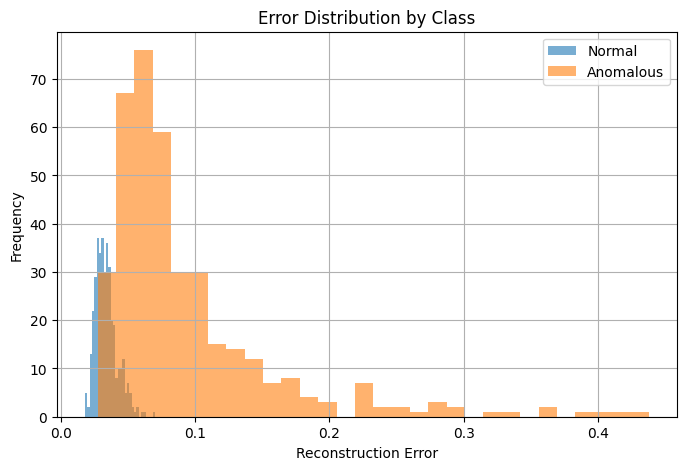

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score

plt.figure(figsize=(8, 5))
plt.hist([e for e, l in zip(errors, labels) if l == 0], bins=30, alpha=0.6, label='Normal')
plt.hist([e for e, l in zip(errors, labels) if l == 1], bins=30, alpha=0.6, label='Anomalous')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution by Class")
plt.legend()
plt.grid(True)
plt.show()

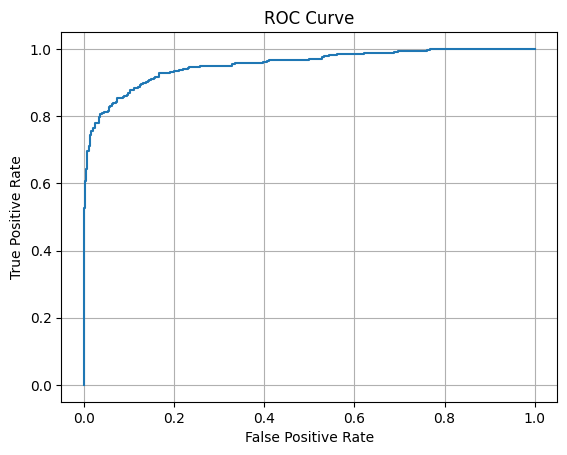

In [94]:
fpr, tpr, thresholds = roc_curve(labels, errors)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


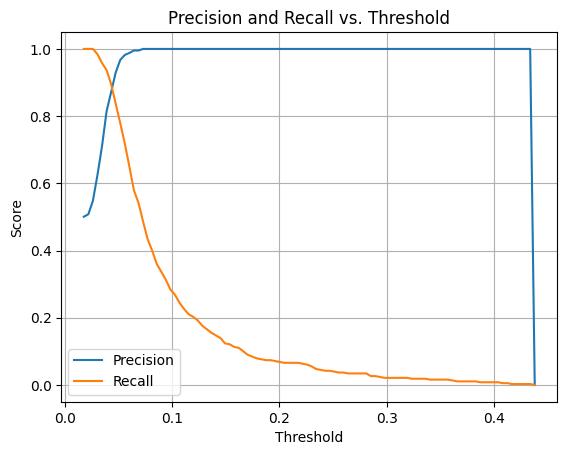

In [111]:
precisions = []
recalls = []
thresholds = np.linspace(min(errors), max(errors), 100)
for t in thresholds:
    preds = [1 if e > t else 0 for e in errors]
    precisions.append(precision_score(labels, preds))
    recalls.append(recall_score(labels, preds))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

#### Leverage Youden's J Statistic to Find Optimal Threshold from ROC Curve

In [95]:
j_scores = tpr - fpr
j_best_idx = np.argmax(j_scores)
optimal_thresh = thresholds[j_best_idx]

print(f"Optimal threshold by Youden's J: {optimal_thresh:.4f}")

Optimal threshold by Youden's J: 0.0468


#### Precision, Recall, ROC AUC Score

In [100]:
preds = [1 if e > optimal_thresh else 0 for e in errors]
cm = confusion_matrix(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
auc = roc_auc_score(labels, errors)

print(f"New Confusion Matrix:\n{cm}")
print(f"New Precision: {precision:.4f}, Recall: {recall:.4f}")
print(f"ROC AUC Score: {auc:.4f}")

New Confusion Matrix:
[[352  28]
 [ 57 323]]
New Precision: 0.9202, Recall: 0.8500
ROC AUC Score: 0.9533


<ipython-input-109-c624856b2d5a>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x="Metric", y="Value", data=metrics_df, palette="viridis")


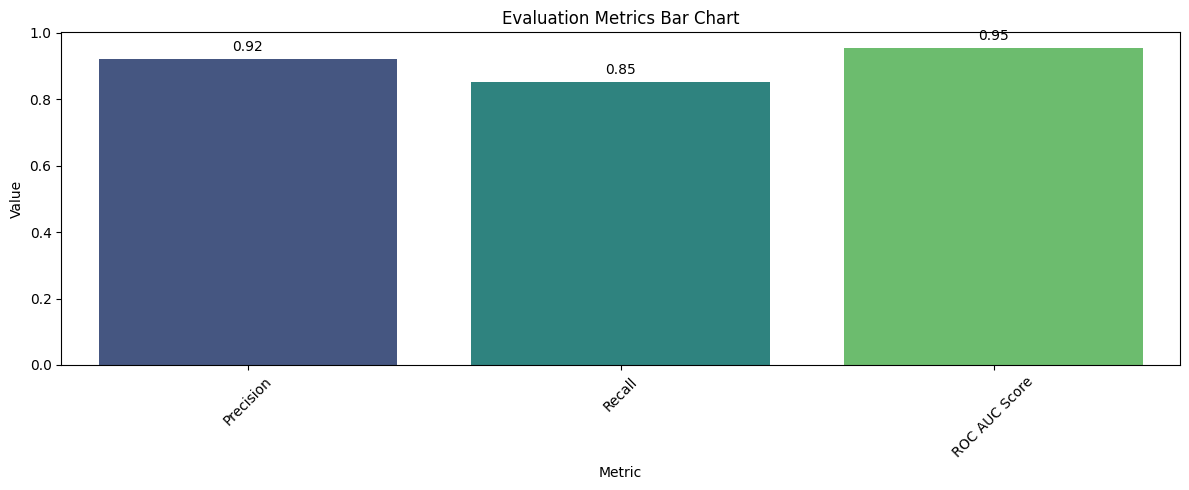

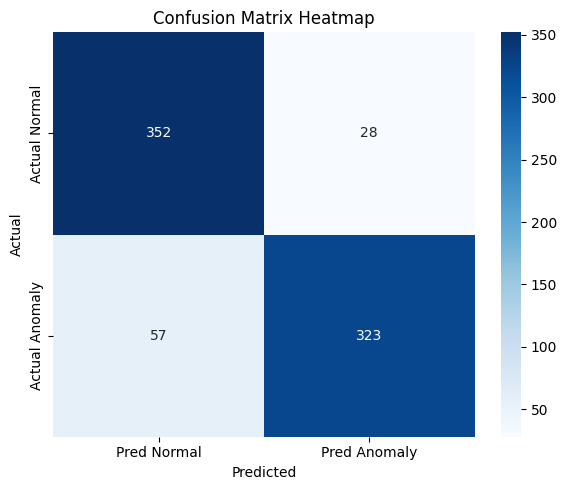

In [109]:
# Evaluation Metrics Summary
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TN, FP = cm[0]
FN, TP = cm[1]

results = {
    "Metric": ["Precision", "Recall", "ROC AUC Score"],
    "Value": [precision, recall, auc]
}
metrics_df = pd.DataFrame(results)

# Bar Chart
plt.figure(figsize=(12, 5))
barplot = sns.barplot(x="Metric", y="Value", data=metrics_df, palette="viridis")

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points')

plt.title("Evaluation Metrics Bar Chart")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap
conf_matrix = np.array([[TN, FP], [FN, TP]])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred Normal", "Pred Anomaly"], yticklabels=["Actual Normal", "Actual Anomaly"])
plt.title("Confusion Matrix Heatmap")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

### Visualizing the 20 Most Anomalous or Defective Predictions

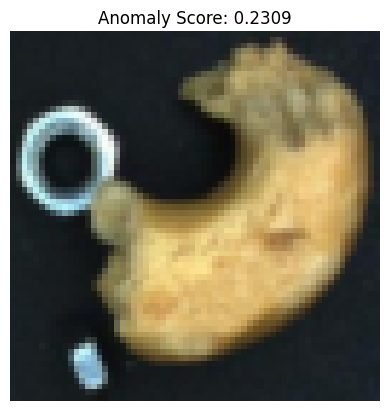

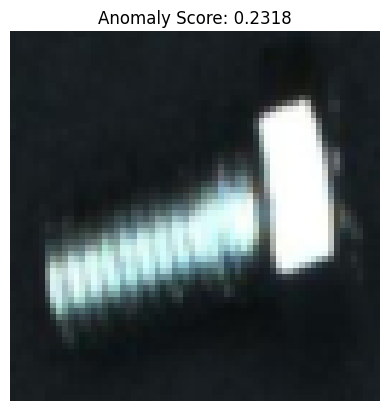

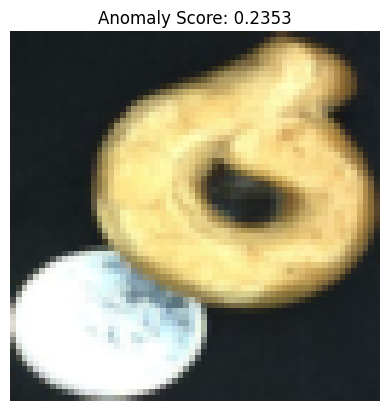

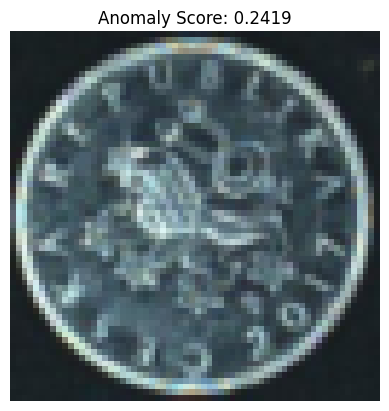

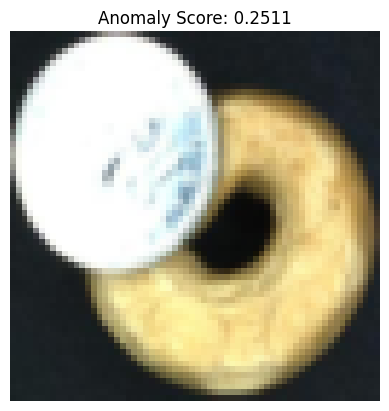

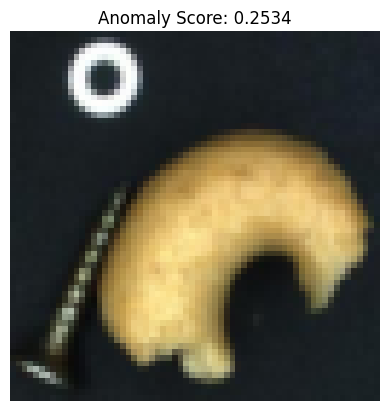

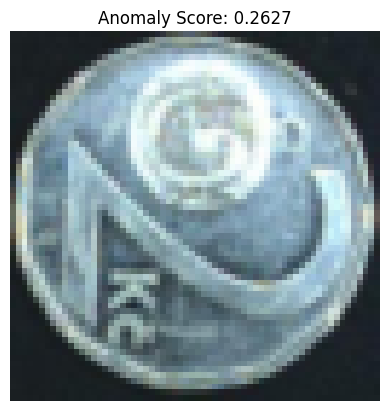

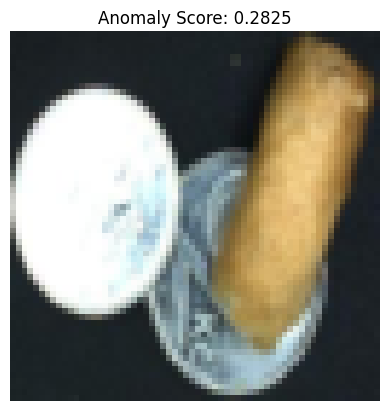

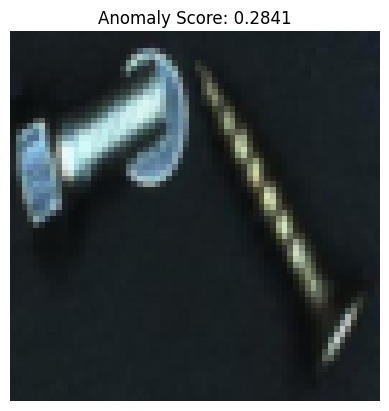

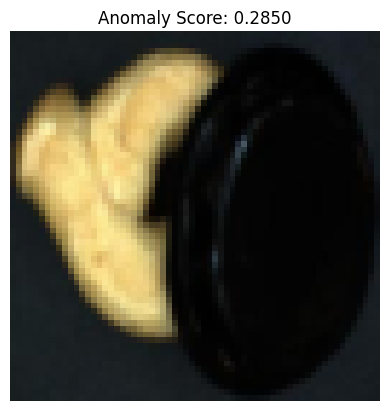

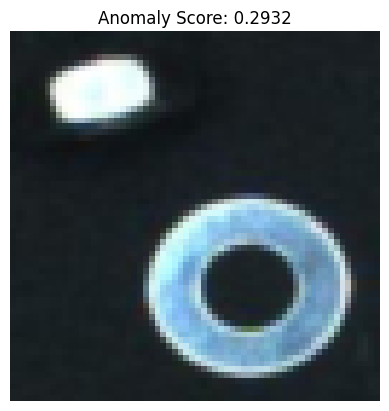

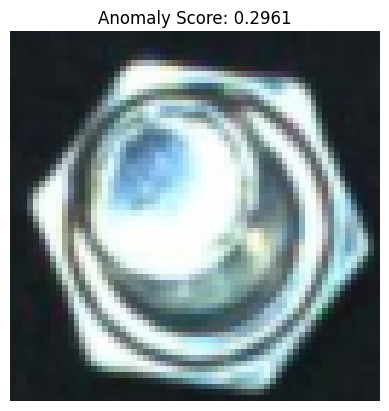

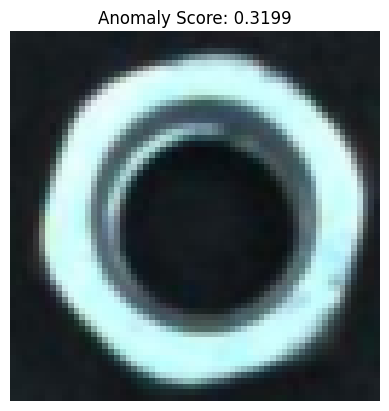

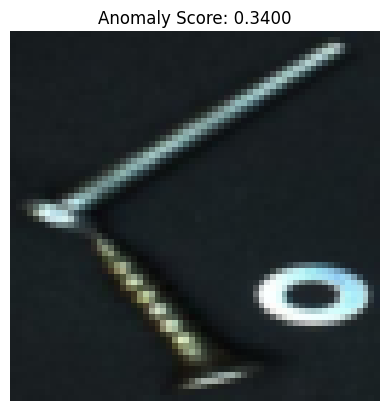

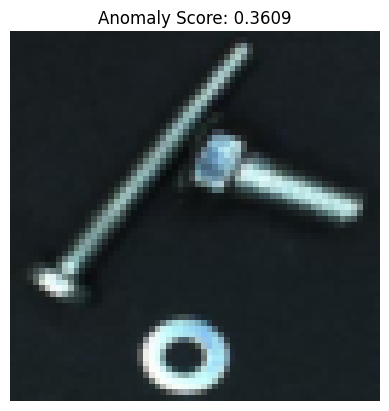

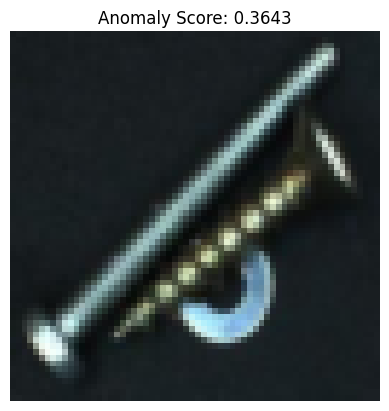

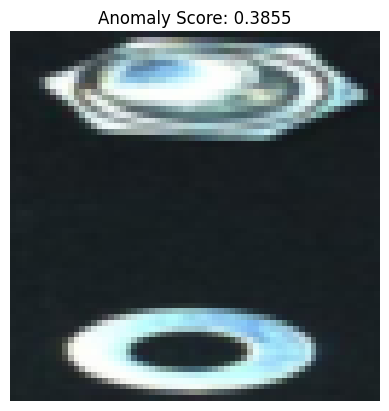

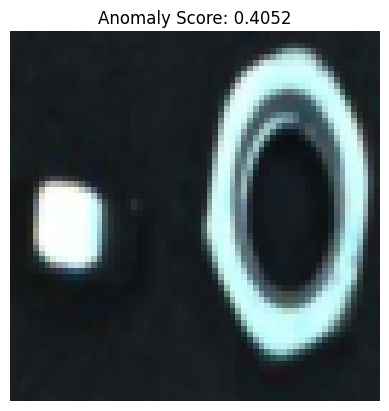

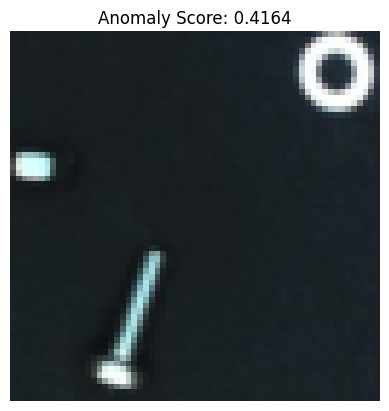

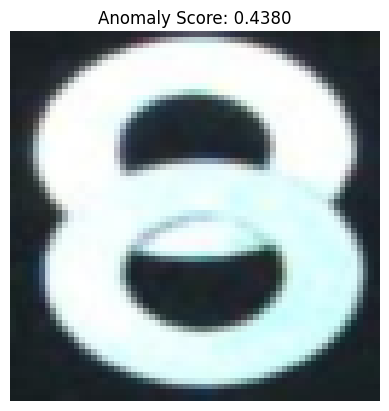

In [114]:
top_anomalies = np.argsort(errors)[-20:]
for idx in top_anomalies:
    img_tensor, _ = balanced_eval_set[idx]
    plt.imshow(img_tensor.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    plt.title(f"Anomaly Score: {errors[idx]:.4f}")
    plt.axis("off")
    plt.show()

The visualizations above are the top 20 "most anomalous" or defective images from the evaluation set that the GAN assigned the highest anomaly scores to. These scores represent how poorly the GAN's generator was able to reconstruct each image compared to the input — higher scores suggest a stronger deviation from what the model learned as "normal." The use of np.argsort(errors)[-20:] selects the indices of the worst (most anomalous) reconstructions. Each image is shown with its corresponding anomaly score as a title. This helps visually inspect which samples were flagged as most suspicious by the model.

Intuitvely and visually, this validates that our model has done well in learning the non-defective biscuits / thus higher reconstruction errors for defective biscuits as we can see clear visual defects in each of the images above.

### Visualizing the 20 Least Anomalous or Defective Predictions

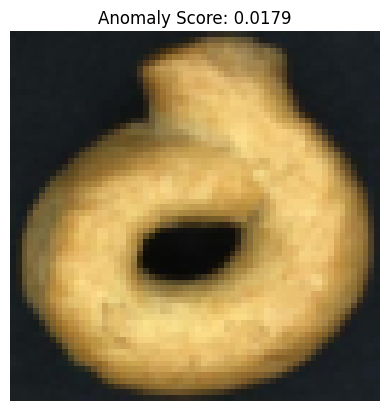

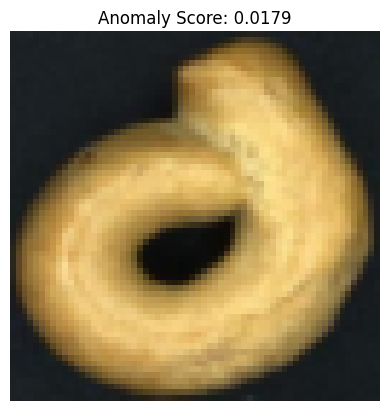

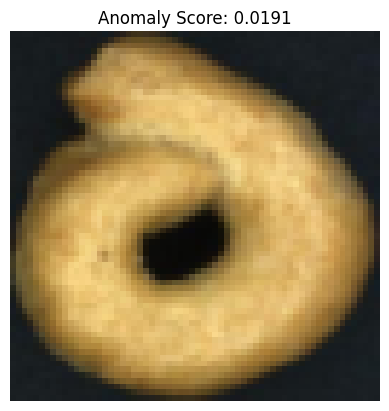

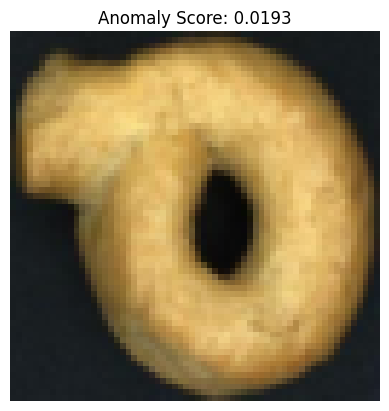

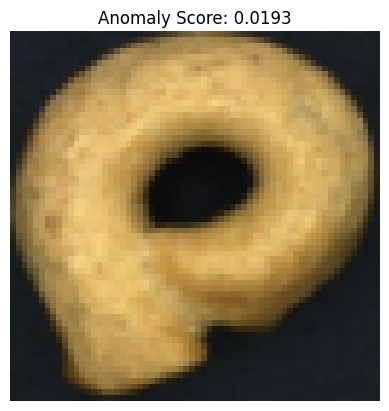

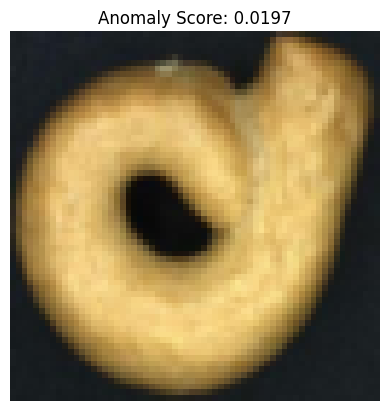

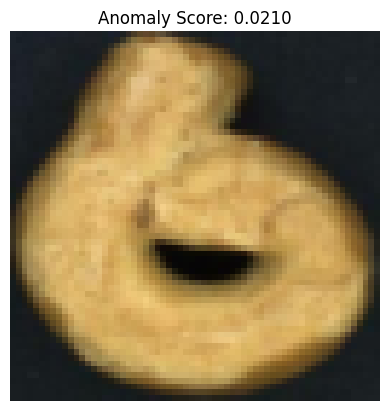

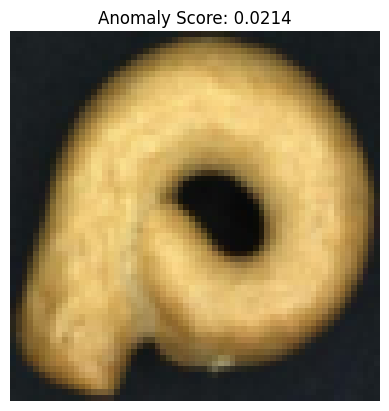

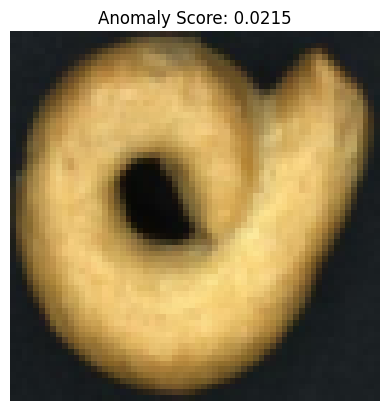

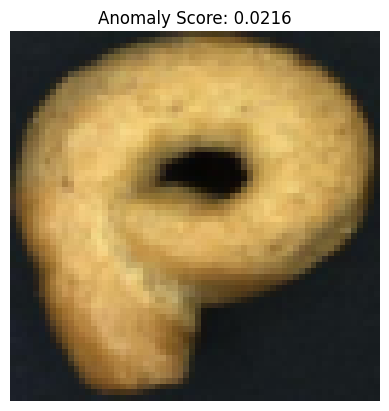

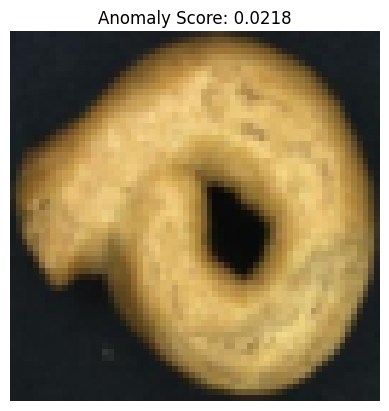

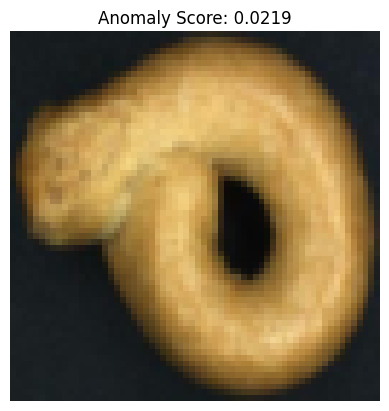

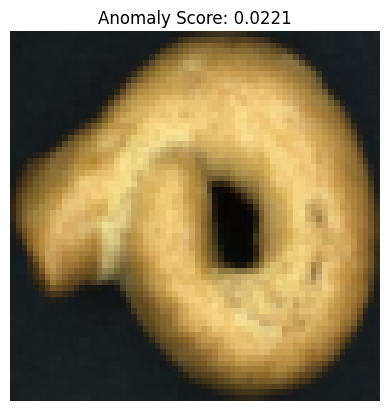

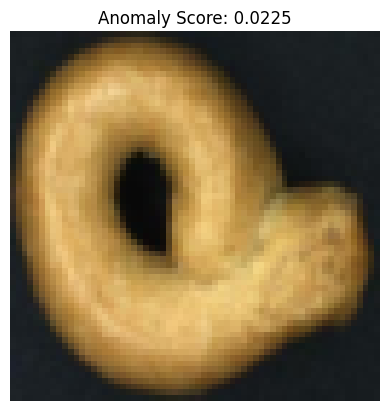

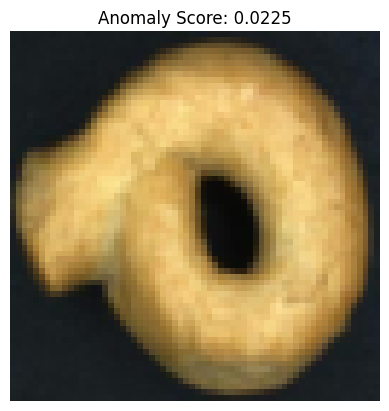

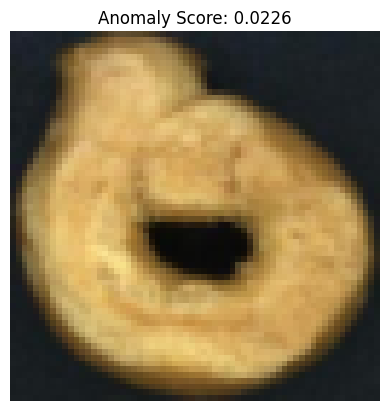

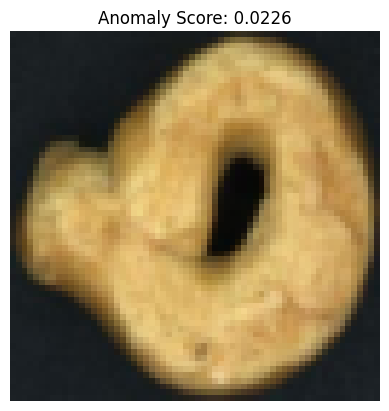

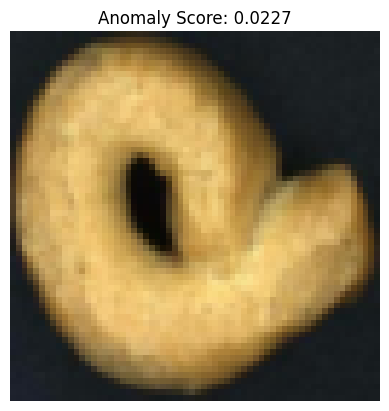

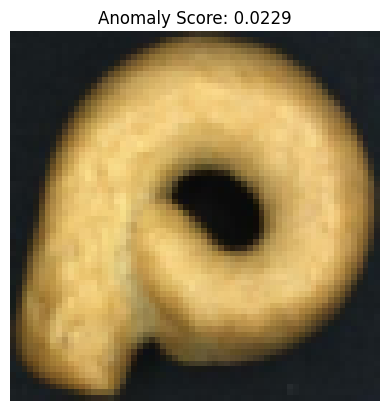

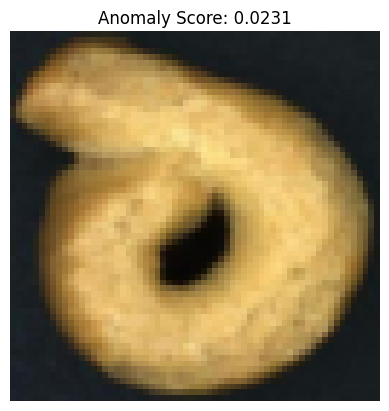

In [115]:
least_anomalous = np.argsort(errors)[:20]
for idx in least_anomalous:
    img_tensor, _ = balanced_eval_set[idx]
    plt.imshow(img_tensor.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
    plt.title(f"Anomaly Score: {errors[idx]:.4f}")
    plt.axis("off")
    plt.show()

Conversely, the set of visualizations above are the top 20 "least anomalous" or most normal images from the evaluation set that the GAN assigned the lowest anomaly scores to. Again, intuitvely and visually, this validates that our model has done well in learning the non-defective biscuits as we can see that the images shown (which have the lowest reconstruction error) are visually non-defective.